# Neural style transfer

In [1]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
# Download images and choose a style image and a content image
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path   = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [4]:
# Define a function to load an image and limit its maximum dimension to 512 pixels

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)  
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, (300, 400))

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 384, 512, 3)
(1, 384, 512, 3)


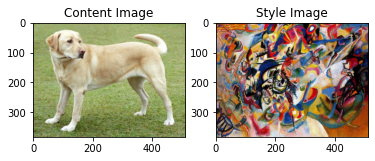

In [6]:
content_image = load_img(content_path)
style_image   = load_img(style_path)

print(content_image.shape)
print(style_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [7]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [8]:
# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [9]:
# create the model:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

style_extractor = vgg_layers(style_layers)
style_outputs   = style_extractor(style_image*255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  834.0474
  mean:  32.09184

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  4465.336
  mean:  183.67836

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  8667.727
  mean:  214.46413

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  20299.61
  mean:  706.3437

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  3293.7786
  mean:  52.04781



In [10]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [11]:
extractor = StyleContentModel(style_layers, content_layers)
results   = extractor(tf.constant(content_image))

In [12]:
style_targets   = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [29]:
print(content_image.shape)
image = tf.Variable(tf.random.uniform(content_image.shape, minval=0, maxval=1))
print(image.shape)
print(image[0].numpy().shape)

(1, 384, 512, 3)
(1, 384, 512, 3)
(384, 512, 3)


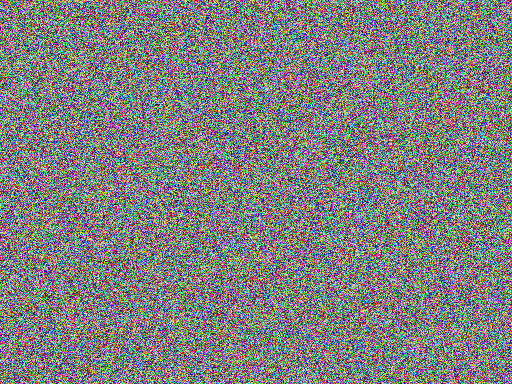

In [30]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

display.display(tensor_to_image(image))

fname = '/content/gdrive/My Drive/data/style_transfer/two_content_loss_v2/at_%d.png' % 0
mpl.image.imsave(fname, image[0].numpy())

In [31]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight   = 1e1
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs   = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

In [32]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

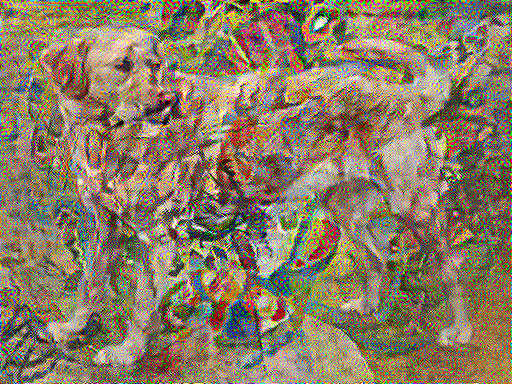

Train step: 12000
Total time: 760.0


In [33]:
import time
start = time.time()

epochs = 40
steps_per_epoch = 300

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

  fname = '/content/gdrive/My Drive/data/style_transfer/two_content_loss_v2/at_%d.png' % (n+1)
  mpl.image.imsave(fname, image[0].numpy())
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [27]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>